In [63]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from random import randint

In [2]:
#from sim import Car, Highway

In [84]:
"""
# simulating a highway

- discrete event simulation
- our goal: to implement a realistic simulation of Avenida General Paz (AGP) from Liniers to Lugones
- we want to:
- quantify the statistics of travel times and their dependence on maximum legal speed, traffic density, average driver behavior, etc
- explore traffic shock waves
- introduce a realistic mechanism for infrequent collisions and recovery
- quantify the probability of an accident in the next ten minutes for a driver that is surrounded by high density traffic
- think how to improve welfare (tolls, broadcasting, fines, etc) model changing lanes. cars sharing the road with trucks. mix humans with self-driving cars
- anything else that you might find interesting and non trivial

## how do you drive?

- what information do you use when driving?
- what actions do you take when driving?
- what constraints do you face?
- how rapidly do you react when driving?

## agents in a highway

- what is a natural definition for an agent?
- what is a reasonable goal for an agent?
- what are the state variables that describe the state of an agent?
- what information is available to an agent?
- is there randomness in the behavior of an agent?

## the environment

- how can Avenida Gral Paz (AGP) be represented? dimensions for AGP?
- how many lanes?
- how do cars enter / exit AGP?

## coding the model

- how do we represent a collection of cars in AGP?
- how do we measure distance?
- what is the initial state of the highway?
- how do we represent the passage of time? reasonable clock?
- how do we represent the movement of cars?
- what is the quantitative outcome of our simulation?

## First idea

### Data Types

AGP is a Queue of Cars. So Single Lane.

Car has properties:

Each car has a position (x) and a velocity (v)s
and a maximum velocity (vmax).
maybe an acceleration (a) and a length (l) too.

Each car has a driver.
The driver has a reaction time (tr) and a desired velocity (vd).

Each car has a front car and a back car.
The front car is the one in front of it in the queue.
The back car is the one behind it in the queue.

Each car can calculate:
- its distance to the front car (df)
- its distance to the back car (db).

By asking the front car for its position and the back car for its position.

(If each car has a lenght take it into account when calculating df and db)

Also each car should know its elapsed time (t) since it entered the highway.

Car properties:
- position (x)
- velocity (v)
- maximum velocity (vmax)
- acceleration (a)
- length (l)
- reaction time (tr)
- desired velocity (vd)
- front car (fc)
- back car (bc)
- elapsed time (t)

### Behavior

A car can accelerate, decelerate, or keep its velocity.
Cars prefer not to crash into each other.

A car can accelerate if its velocity is less than its maximum velocity.

¿Can a car calculate how long would it take to reach the front car if it accelerates?

A car can maybe know also the velocity of the front car.

A car can decelerate if its distance to the front car is less than its velocity.

A car can keep its velocity if its distance to the front car is equal or greater than its velocity.

If its position is equal to the length of the highway, it can exit the highway.

"""

from typing import Optional


class Car:
    def __init__(
        self,
        x: float,
        v: float,
        vmax: float,
        a: float,
        l: float,
        tr: float,
        vd: float,
        bc: "Car",
        fc: Optional["Car"] = None,
        will_measure: Optional[bool] = False,
    ):

        self.t = 0

        self.x = x
        self.v = v
        self.vmax = vmax
        self.a = a
        self.length = l

        self.reaction_time = tr
        self.desired_velocity = vd

        self.f_car = fc
        self.b_car = bc

        self.will_measure = will_measure
        

    def __str__(self):
        return f"Car(x={self.x}, v={self.v}, vmax={self.vmax}, a={self.a}, l={self.length}, tr={self.reaction_time}, vd={self.desired_velocity}, fc={self.f_car}, bc={self.b_car})"

    def __repr__(self):
        return f"Car(x={self.x}, v={self.v}, vmax={self.vmax}, a={self.a}, l={self.length}, tr={self.reaction_time}, vd={self.desired_velocity}, fc={self.f_car}, bc={self.b_car})"

    def check_crash(self):
        if self.distance_to_front_car() < 0:
            print("Crash!")
            return True
        else:
            return False

    def check_rear_end(self):
        if self.distance_to_back_car() < 0:
            print("Rear end!")
            return True
        else:
            return False

    def accelerate(self):
        if self.v < self.vmax:
            self.v = self.v + self.a
        else:
            self.v = self.vmax

    def decelerate(self):
        if self.f_car is not None:
            if self.f_car.x - self.x < self.v:
                self.v = self.f_car.x - self.x

    def keep_velocity(self):
        pass

    def distance_to_front_car(self):
        if self.f_car is not None:
            return self.f_car.x - self.x
        else:
            return None

    def distance_to_back_car(self):
        if self.bc is not None:
            return self.x - self.bc.x
        else:
            return None

    def move(self):
        self.x = self.x + self.v

    def get_position(self):
        return self.x

    def custom_behavior(self):
        #if self.x > 300 and self.x < 1000:
        #    self.v = 40

        # random behavior
        if randint(0, 100) < 10:
            if self.v > 0:
                self.v += randint(-1, 1) * 30
            else:
                self.v += randint(0, 10)

    def update(self):
        self.custom_behavior()
        self.accelerate()
        self.decelerate()
        self.keep_velocity()
        self.move()

        self.t += 1

class Highway:
    def __init__(self, length: float):
        self.length = length
        self.cars = []
        self.time = 0

    def __str__(self):
        return f"Highway(length={self.length}, cars=[\n" + "\n".join(
            [f"\t{car}" for car in self.cars]
        ) + "\n])"

    def __repr__(self):
        return f"Highway(length={self.length}, cars=[\n" + "\n".join(
            [f"\t{car}" for car in self.cars]
        ) + "\n])"

    def add_car(self, car: Car):

        if len(self.cars) > 0:
            car.b_car = self.cars[-1]
            self.cars[-1].f_car = car

        self.cars.append(car)

    def update(self):
        for car in self.cars:
            car.update()

            if car.get_position() > self.length:
                self.cars.remove(car)

            if len(self.cars) > 0:
                self.cars[-1].f_car = None
        
        if len(self.cars) == 0:
            return 2
    
        return 1

    def run(self, time: float):
        pass

    def measure(self):
        pass

    def plot(self):
        fig, ax = plt.subplots()
        ax.plot([car.x for car in self.cars], [0 for car in self.cars], "o")
        ax.set_xlim(0, self.length)
        ax.set_ylim(-1, 1)
        ax.set_yticks([])
        ax.set_xlabel("Position")
        ax.set_title("Highway")
        ax.legend()
        
        plt.show()

    def get_cars(self):
        return self.cars

    def get_cars_positions(self):
        return [car.get_position() for car in self.cars]

    def get_cars_velocities(self):
        return [car.v for car in self.cars]

    def get_cars_accelerations(self):
        pass

    def get_cars_distances(self):
        pass

    def get_cars_times(self):
        return [car.t for car in self.cars]

    def get_cars_reaction_times(self):
        pass

    def get_cars_desired_velocities(self):
        pass

    def get_cars_front_cars(self):
        pass

    def get_cars_back_cars(self):
        pass


In [3]:
agp = Highway(length = 1000)

agp.add_car(Car(x=0, v=0, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=100, v=0, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=200, v=0, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=300, v=0, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=400, v=0, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


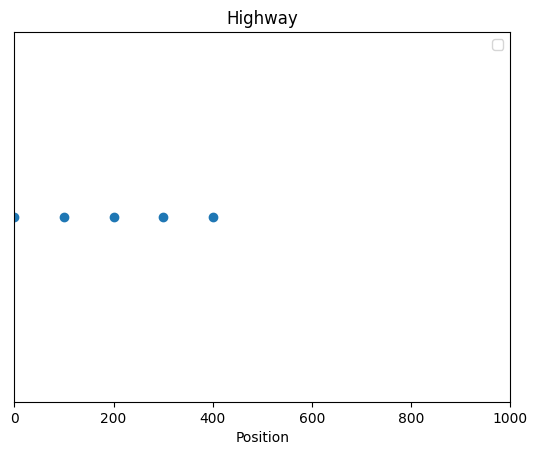

In [4]:
agp.plot()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


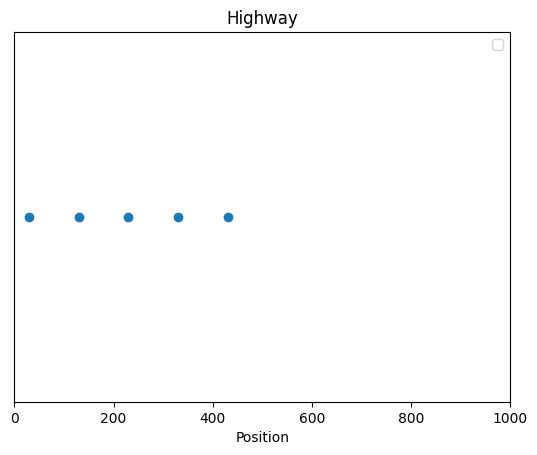

In [15]:
agp.update()
agp.plot()

In [16]:
agp

Highway(length=1000, cars=[
	Car(x=30, v=10, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None)
	Car(x=130, v=10, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None)
	Car(x=230, v=10, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None)
	Car(x=330, v=10, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None)
	Car(x=430, v=10, vmax=120, a=2, l=5, tr=1, vd=120, fc=None, bc=None)
])

In [68]:
# set random seed
import random
random.seed(42)

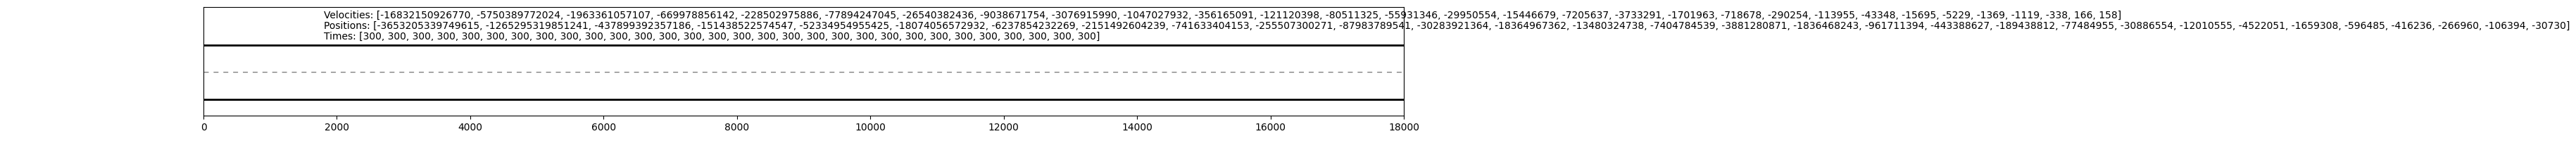

In [83]:
agp = Highway(length = 18000)

agp.add_car(Car(x=0  , v=0, vmax=120, a=14, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=100, v=0, vmax=100, a=3, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=200, v=0, vmax=110, a=4, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=300, v=0, vmax=150, a=3, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))
agp.add_car(Car(x=400, v=0, vmax=200, a=100, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))

# Add 10 more cars
for i in range(30):
    agp.add_car(Car(x=500 + i*100, v=0, vmax=120 + i*2, a=5, l=5, tr=1, vd=120, fc=None, bc=None, will_measure=True))

fig, ax = plt.subplots(figsize=(22, 2))

ax.set_xlim(0, agp.length)
ax.set_ylim(-8, 12)

# ax hide y axis
ax.set_yticks([])

# Hide the right and top spines
# ax.spines['left'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.spines['bottom'].set_visible(False)

# Plot lane lines
ax.plot([2, agp.length], [5, 5], color='black', linewidth=2)
ax.plot([2, agp.length], [-5, -5], color='black', linewidth=2)

# Plot dashed center line
ax.plot([2, agp.length], [0, 0], color='grey', linewidth=1, linestyle='dashed', dashes=(5, 5))

#car_im = OffsetImage(plt.imread('car.png', format="png"), zoom=.2)
car_colors = ['car_r', 'car_y', 'car_b', 'car_k']
car_ims = [OffsetImage(plt.imread(f'assets/{car_color}.png', format="png"), zoom=.2) for car_color in car_colors]

# Animate with AnnotationBbox for each car
def init():
    return []

def update(frame):

    # Delete previous rendered cars
    for artist in ax.artists:
        artist.remove()
    
    # Clear previous text
    # ax.texts = [] AttributeError: can't set attribute
    # fix
    for txt in ax.texts:
        #txt.set_visible(False)
        txt.remove()

    status = agp.update()

    if not status:
        # Stop animation
        # return []
        pass
    
    xdata = agp.get_cars_positions()
    ydata = [0 for _ in range(len(xdata))]
    vdata = agp.get_cars_velocities()
    tdata = agp.get_cars_times()

    artists = []
    for i, (x, y, v) in enumerate(zip(xdata, ydata, vdata)):
        ab = AnnotationBbox(
            car_ims[i % len(car_ims)], (x, y), frameon=False)
        artists.append(ax.add_artist(ab))
        
    # Plot car velocities and positions as text
    ax.text(0.1, 0.9, f"Velocities: {vdata}", transform=ax.transAxes)
    ax.text(0.1, 0.8, f"Positions: {xdata}", transform=ax.transAxes)
    ax.text(0.1, 0.7, f"Times: {tdata}", transform=ax.transAxes)

    return artists

ani = animation.FuncAnimation(fig, update, frames=300, init_func=init, blit=True, interval=100)

# save the animation as an mp4.  This requires ffmpeg

ani.save('animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])